In [1]:
from casadi import *
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
T = 15. # Time horizon
N = 100 # number of control intervals
x = MX.sym('x', 3)
u = MX.sym('u', 1)
lbd = MX.sym('lbd', 3)
N_pop = 5.3e6
u_min = 0.5
u_max = 6.5
Wu_max = N_pop**2/(u_max-u_min)*1e15
Wu_k = 2
Wu_list = [Wu_k]
while Wu_k < Wu_max:
    Wu_k = Wu_k**2
    Wu_list.append(Wu_k)
alpha = 0.2
beta = u*alpha
I0 = 2000
x0 = [N_pop - I0, I0, 0]

In [3]:
xdot = vertcat(-u*x[0]*x[1]/N_pop, u*x[0]*x[1]/N_pop - alpha*x[1], alpha*x[1])
lbd_dot = vertcat(0 - lbd[0]*u*x[1]/N_pop - lbd[1]*u*x[0]/N_pop, 2*x[1] + lbd[0]*u*x[1]/N_pop + lbd[1]*u*x[0]/N_pop, lbd[2]*alpha)
w = vertcat(x, lbd)
wdot = vertcat(xdot, lbd_dot)
F = Function('F', [w, u], [wdot])
Fx = Function('Fx', [x, u], [xdot])

In [4]:
def RK4_Integrator(f, X, U, DT):
       k1 = f(X, U)
       k2 = f(X + DT/2 * k1, U)
       k3 = f(X + DT/2 * k2, U)
       k4 = f(X + DT * k3, U)
       X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
       return X

In [5]:

x0 = [N_pop-I0, I0, 0]
M = 50
t = np.linspace(0,T,N)
dt = np.diff(t)[0]/M
wk = w
x_plot = [x0]
for i in range(M):
    wk = RK4_Integrator(F, wk, u, dt)
    x_plot.append(wk[:3])

x_end = wk[:3]
lbd_end = wk[3:]
f_lbd = Function('f_lbd', [x, lbd, u], [lbd_end])
f = Function('f', [w, u], [wk])

lbd_k = lbd
xk = x0
U = MX.sym('U', len(t))
Wu = Wu_max

In [6]:
def argmin_H_u(x, lbd):
    return 1/(2*Wu)*(lbd[1]-lbd[0])*x[0]*x[1]/N_pop
def Hamiltonian(x, lbd, u):
    return x[1]**2 - Wu*u**2 + (lbd[1]-lbd[0])*x[0]*x[1]*u/N_pop + (lbd[2]-lbd[1])*alpha*x[1]

In [7]:
xk = x0
lbd_k = [0.5,0.2,0.3]
u_sols = []
Wu_list = np.logspace(0,np.log2(Wu_max),15, base=2)
#Wu_list = np.linspace(0,Wu_max,15)

x_sols = []
lbd_sols = []
for Wu in tqdm(Wu_list):
    def Hamiltonian(x, lbd, u):
        return x[1]**2 - Wu*u**2 + (lbd[1]-lbd[0])*x[0]*x[1]*u/N_pop + (lbd[2]-lbd[1])*alpha*x[1]
    u_list = []
    x_list = []
    lbd_list = []
    wk = vertcat(DM(xk), DM(lbd_k))
    xk = x0
    lbd_k = [0.1,0.2,0.3]
    for i in range(len(t)):
        S = wk[0]
        I = wk[1]
        lbd = wk[3:]
        #uk = 1/(2*Wu)*(lbd_k[1]-lbd_k[0])*S*I/N_pop
        H1 = Hamiltonian(xk, lbd_k, u_min)
        H2 = Hamiltonian(xk, lbd_k, u_max)
        print(H1, H2)
        if H1 < H2:
            uk = u_min
        else:
            uk = u_max
#        if uk < u_min:
#            uk = u_min
#        elif uk > u_max:
#            uk = u_max
            
        lbd_k = f_lbd(xk, lbd_k, uk)
        wk = f(wk, uk)
        u_list.append(uk)
        x_list.append(wk[:3].full())
        lbd_list.append(wk[3:].full())
    u_sols.append(u_list)
    x_sols.append(x_list)
    lbd_sols.append(lbd_list)

 27%|██████████████████████▏                                                            | 4/15 [00:00<00:00, 13.25it/s]

4000139.712264151 4001297.2594339624
4.41017e+006 1.24226e+007
4.90122e+006 2.21403e+007
5.47965e+006 3.32562e+007
6.15234e+006 4.58804e+007
6.92669e+006 6.01314e+007
7.81071e+006 7.61371e+007
8.81301e+006 9.40356e+007
9.9429e+006 1.13976e+008
1.12104e+007 1.36118e+008
1.26264e+007 1.60635e+008
1.42024e+007 1.87715e+008
1.59512e+007 2.17558e+008
1.78863e+007 2.50382e+008
2.00223e+007 2.86422e+008
2.23751e+007 3.25929e+008
2.49616e+007 3.69178e+008
2.78003e+007 4.16461e+008
3.0911e+007 4.68097e+008
3.43151e+007 5.24427e+008
3.80356e+007 5.85822e+008
4.20975e+007 6.52678e+008
4.65276e+007 7.25425e+008
5.13548e+007 8.04528e+008
5.66104e+007 8.90485e+008
6.2328e+007 9.83835e+008
6.85441e+007 1.08516e+009
7.52977e+007 1.19509e+009
8.26311e+007 1.31429e+009
9.05901e+007 1.44351e+009
9.92236e+007 1.58352e+009
1.08585e+008 1.73517e+009
1.18731e+008 1.89938e+009
1.29724e+008 2.07715e+009
1.4163e+008 2.26952e+009
1.54521e+008 2.47765e+009
1.68474e+008 2.70279e+009
1.83574e+008 2.94626e+009
1.999

 40%|█████████████████████████████████▏                                                 | 6/15 [00:00<00:00, 13.17it/s]

-16126381.45534901 -3397380780.06719
-1.45852e+007 -3.36968e+009
-8.76548e+006 -3.27351e+009
8.49504e+006 -2.99428e+009
5.6349e+007 -2.2255e+009
1.86012e+008 -1.47674e+008
5.34436e+008 5.43065e+009
5.78619e+008 6.1395e+009
6.26326e+008 6.90474e+009
6.77833e+008 7.73078e+009
7.33439e+008 8.62241e+009
7.93466e+008 9.5848e+009
8.58263e+008 1.06235e+010
9.28204e+008 1.17445e+010
1.00369e+009 1.29543e+010
1.08517e+009 1.42599e+010
1.1731e+009 1.56688e+010
1.26799e+009 1.71891e+010
1.3704e+009 1.88295e+010
1.4809e+009 2.05997e+010
1.60015e+009 2.25096e+010
1.72882e+009 2.45704e+010
1.86766e+009 2.67939e+010
2.01746e+009 2.91928e+010
2.1791e+009 3.17811e+010
2.35349e+009 3.45735e+010
2.54165e+009 3.75861e+010
2.74465e+009 4.08362e+010
2.96366e+009 4.43426e+010
3.19995e+009 4.81254e+010
3.45486e+009 5.22062e+010
3.72987e+009 5.66086e+010
4.02655e+009 6.13578e+010
4.34661e+009 6.64811e+010
4.69189e+009 7.20079e+010
5.06437e+009 7.797e+010
5.4662e+009 8.44016e+010
5.89966e+009 9.13395e+010
6.367

 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:00<00:00, 12.80it/s]

1.43081e+015
2.74213e+014 1.77065e+015
2.97122e+014 2.13722e+015
3.21832e+014 2.53262e+015
3.48485e+014 2.95911e+015
3.77234e+014 3.41913e+015
4.08244e+014 3.91533e+015
4.41692e+014 4.45056e+015
4.77771e+014 5.02787e+015
5.16687e+014 5.65057e+015
5.58663e+014 6.32225e+015
6.0394e+014 7.04675e+015
6.52777e+014 7.82822e+015
7.05455e+014 8.67114e+015
7.62275e+014 9.58034e+015
8.23564e+014 1.0561e+016
8.89672e+014 1.16189e+016
9.60979e+014 1.27599e+016
1.03789e+015 1.39906e+016
1.12086e+015 1.53181e+016
1.21034e+015 1.675e+016
1.30687e+015 1.82945e+016
1.41098e+015 1.99605e+016
1.52328e+015 2.17575e+016
1.64441e+015 2.36958e+016
1.77507e+015 2.57865e+016
1.916e+015 2.80416e+016
2.06802e+015 3.0474e+016
2.23198e+015 3.30978e+016
2.40885e+015 3.59278e+016
2.59962e+015 3.89804e+016
2.80539e+015 4.22731e+016
3.02735e+015 4.58247e+016
3.26675e+015 4.96555e+016
3.52499e+015 5.37876e+016
3.80353e+015 5.82447e+016
4.10397e+015 6.30522e+016
4.42804e+015 6.82378e+016
4.7776e+015 7.38312e+016
5.15464

 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:00<00:00, 13.19it/s]

-1.4538238406688692e+19 -2.456962290731061e+21
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.45382e+019 -2.45696e+021
-1.4538e+019 -2.45696e+021
-1.45377e+019 -2.45695e+021
-1.45368e+019 -2.45694e+021
-1.45344e+019 -2.4569e+021
-1.4528e+019 -2.4568e+021
-1.4511e+019 -2.45653e+021
-1.44653e+019 -2.4558e+021
-1.43432e+019 -2.45384e+021
-1.40166e+019 -2.44862e+021
-1.31434e+019 -2.43464e+021
-1.08083e+019 -2.39728e+021
-4.56424e+018 -2.29736e+021
1.21328e+019 -2.03019e+021
5.67816e+019 -1.31574e+021
1.76175e+020 5.94723e+020
1.91172e+020 8.347e+020
2.07349e+020 1.

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 12.76it/s]

 2.48997e+027
1.69202e+026 2.68751e+027
1.82518e+026 2.90058e+027
1.96881e+026 3.13041e+027
2.12373e+026 3.37831e+027
2.29084e+026 3.64571e+027
2.47109e+026 3.93413e+027
-1.2356154206480002e+25 -2.0881900608951203e+27
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+027
-1.23562e+025 -2.08819e+02

In [8]:
x_sols = [np.array(sol) for sol in x_sols]

In [9]:
x_sols[0].shape
tgrid = np.linspace(0,T, N)

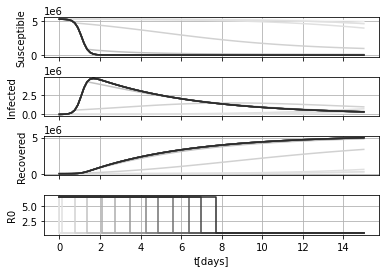

In [10]:
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

colormap = cm.get_cmap('Greys', len(x_sols))
colors = colormap(np.linspace(.1, .8, len(x_sols)))

fig2, ax2 = plt.subplots(4)
marker = ''
for i, (u_sol, x_sol, lbd_sol, color) in enumerate(zip(u_sols, x_sols, lbd_sols, colors)):
    if i == (len(x_sols)-1):
        marker = ''
    ax2[0].plot(tgrid, x_sol[:,0], color=color, marker=marker,markersize=2.5)
    ax2[1].plot(tgrid, x_sol[:,1], color=color, marker=marker,markersize=2.5)
    ax2[2].plot(tgrid, x_sol[:,2], color=color, marker=marker,markersize=2.5)
    ax2[3].step(tgrid, u_sol, color=color, marker=marker,markersize=2.5)
_ = [x.grid() for x in ax2]
_ = [x.set_xticklabels([]) for x in ax2[:-1]]

_ = [x.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) for x in ax2[:-1]]
_ = [x.set_ylabel(s) for x, s in zip(ax2, ['Susceptible', 'Infected', 'Recovered', 'R0'])]
ax2[-1].set_xlabel('t[days]')
fig2.subplots_adjust(hspace=.5)

In [11]:
lbd_k

DM([-5.89841e+026, 5.89841e+026, 6.21105])